# Détection de tous les attaques en précisant leurs types (BF/SQL/XSS)  

### Import data

In [1]:
# normal:12000 brut force:12000 sql:236 xss:452
import pandas as pd 
import numpy as np 
from pandas import Series,DataFrame
bf_logs = pd.read_csv("./data/bf.csv")
normal_logs = pd.read_csv("./data/normal.csv")
sql_logs = pd.read_csv("./data/sql.csv")
xss_logs = pd.read_csv("./data/xss.csv")

In [2]:
# add labels for attacks
bf_logs.label = 1
sql_logs.label = 2
xss_logs.label = 3
xss_logs.head()

,Unnamed: 0,ip_address,date,hour,minute,seconds,protocol,username,password,status,respsize,timed,label
0,0,192.108.116.88,18/Dec/2017,13,0,31,GET,datalab,"';alert(String.fromCharCode(88,83,83))//';aler...",200,1040,183,3
1,1,192.108.116.88,18/Dec/2017,13,0,31,GET,datalab,"';alert(String.fromCharCode(88,83,83))//';aler...",200,945,35,3
2,2,192.108.116.88,18/Dec/2017,13,0,31,GET,datalab,"';alert(String.fromCharCode(88,83,83))//';aler...",200,34463,8,3
3,3,192.108.116.88,18/Dec/2017,13,2,31,POST,datalab,"';alert(String.fromCharCode(88,83,83))//';aler...",-,-,-,3
4,4,192.108.116.88,18/Dec/2017,13,4,31,POST,datalab,"';alert(String.fromCharCode(88,83,83))//';aler...",-,-,-,3


In [3]:
# concatenate
frames = [normal_logs,sql_logs,xss_logs]
data_logs = pd.concat(frames)

### Pré-traitement des données
#### Ajout des nouveaux features comme les longueurs, des symboles spéciaux et des mots spéciaux

In [4]:
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
# obtenir la longueur de lien(information)
def get_len(info_comp):
    return len(info_comp)

# obtenir des symboles spéciaux pour logs sql
def get_sql_char(info_comp):
    return len(re.findall("[?=\*#@%>]", info_comp, re.IGNORECASE))

# obtenir des mots spéciaux pour logs sql
def get_sql_word(info_comp):
    return len(re.findall("(SELECT)|(version)|(comment)|(user)|(FROM)|(mysql)|(host)|(DELET)|(name)|(MYSQL)|(WHERE)|(password)|(ORDER)",info_comp,re.IGNORECASE))

# obtenir des symboles spéciaux pour logs xss
def get_xss_char(info_comp):
    return len(re.findall("[<>\"\'=&{}!#\*]", info_comp, re.IGNORECASE))

# obtenir des mots spéciaux pour logs xss
def get_xss_word(info_comp):
    return len(re.findall("(alert)|(script)|(XSS)|(SRC=)|(xss)|(onerror)|(onload)|(BODY)|(src=)|(INPUT)|(http)|(LINK)|(url=)|(SCRIPT)",info_comp,re.IGNORECASE))

def get_password_number(info_comp):
    return len(re.findall("((?:0(?=1)|1(?=2)|2(?=3)|3(?=4)|4(?=5)|5(?=6)|6(?=7)|7(?=8)|8(?=9)|9(?=0)){2}\d)|((\d)\1{2})",info_comp,re.IGNORECASE))

def get_feature(info_comp):
    return [get_len(info_comp),get_evil_char(info_comp),get_evil_word(info_comp)]


In [5]:
# for non brut force data
f = lambda x: str(x)
data_logs['len']=data_logs['password'].apply(f).apply(get_len)
data_logs['sqlchar']=data_logs['password'].apply(f).apply(get_sql_char)
data_logs['sqlword']=data_logs['password'].apply(f).apply(get_sql_word)
data_logs['xsschar']=data_logs['password'].apply(f).apply(get_xss_char)
data_logs['xssword']=data_logs['password'].apply(f).apply(get_xss_word)
data_logs['passnumber']=data_logs['password'].apply(f).apply(get_password_number)
data_logs.head(2)

,Unnamed: 0,ip_address,date,hour,minute,seconds,protocol,username,password,status,respsize,timed,label,len,sqlchar,sqlword,xsschar,xssword,passnumber
0,0,76.121.199.123,21/Jan/2018,23,59,0,GET,12345678,michael,200,1040,20,0,7,0,0,0,0,0
1,1,76.121.199.123,21/Jan/2018,23,59,1,GET,12345678,michael,200,945,22,0,7,0,0,0,0,0


In [6]:
# for brut force data
bf_logs['len']=bf_logs['password'].apply(f).apply(get_len)
bf_logs['sqlchar']=bf_logs['password'].apply(f).apply(get_sql_char)
bf_logs['sqlword']=bf_logs['password'].apply(f).apply(get_sql_word)
bf_logs['xsschar']=bf_logs['password'].apply(f).apply(get_xss_char)
bf_logs['xssword']=bf_logs['password'].apply(f).apply(get_xss_word)
bf_logs['passnumber']=bf_logs['password'].apply(f).apply(get_password_number)
bf_logs.head(2)

,Unnamed: 0,ip_address,date,hour,minute,seconds,protocol,username,password,status,respsize,timed,label,len,sqlchar,sqlword,xsschar,xssword,passnumber
0,0,136.133.92.208,22/Jan/2018,15,2,1,GET,director,123456,200,1040,312,1,6,0,0,0,0,2
1,1,136.133.92.208,22/Jan/2018,15,2,1,GET,director,123456,200,945,14,1,6,0,0,0,0,2


#### Transformation de la forme de l'adresse IP

In [7]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data_logs['ip_address'] = le.fit_transform(data_logs['ip_address'].apply(f)) 
print(data_logs.head(2))
bf_logs['ip_address'] = le.fit_transform(bf_logs['ip_address'].apply(f)) 
print(bf_logs.head(2))

   Unnamed: 0  ip_address         date  hour  minute  seconds protocol  \
0           0        1796  21/Jan/2018    23      59        0      GET   
1           1        1796  21/Jan/2018    23      59        1      GET   

   username password status respsize timed  label  len  sqlchar  sqlword  \
0  12345678  michael    200     1040    20      0    7        0        0   
1  12345678  michael    200      945    22      0    7        0        0   

   xsschar  xssword  passnumber  
0        0        0           0  
1        0        0           0  
   Unnamed: 0  ip_address         date  hour  minute  seconds protocol  \
0           0           3  22/Jan/2018    15       2        1      GET   
1           1           3  22/Jan/2018    15       2        1      GET   

   username password status respsize timed  label  len  sqlchar  sqlword  \
0  director   123456    200     1040   312      1    6        0        0   
1  director   123456    200      945    14      1    6        0        

In [8]:
del data_logs[data_logs.columns[0]]
del bf_logs[bf_logs.columns[0]]

#### Remplacement des données null au 0

In [10]:
def replace(resp):
    if resp == '-':
        resp = 0
    elif (resp == resp) == False:
        resp = 0
    return (resp)
data_logs['respsize'] = data_logs['respsize'].apply(replace)
data_logs['timed'] = data_logs['timed'].apply(replace)
data_logs['status'] = data_logs['status'].apply(replace)
bf_logs['respsize'] = bf_logs['respsize'].apply(replace)
bf_logs['timed'] = bf_logs['timed'].apply(replace)
bf_logs['status'] = bf_logs['status'].apply(replace)

#### Fonctions pour évaluer la performance

In [11]:
from sklearn import metrics
def do_metrics(y_test,y_pred):
    print ("metrics.confusion_matrix:")
    print (metrics.confusion_matrix(y_test, y_pred))
    print ("metrics.accuracy_score:")
    print (metrics.accuracy_score(y_test, y_pred))
    print ("metrics.precision_score:")
    print (metrics.precision_score(y_test, y_pred))
    print ("metrics.recall_score:")
    print (metrics.recall_score(y_test, y_pred))
    print ("metrics.f1_score:")
    print (metrics.f1_score(y_test,y_pred))

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_cm(cm, labels):
    
    # Compute percentanges
    percent = (cm*100.0)/np.array(np.matrix(cm.sum(axis=1)).T)  # Derp, I'm sure there's a better way
    
    print ('Confusion Matrix Stats')
    for i, label_i in enumerate(labels):
        for j, label_j in enumerate(labels):
            print ("%s/%s: %.2f%% (%d/%d)" % (label_i, label_j, (percent[i][j]), cm[i][j], cm[i].sum()))

    # Show confusion matrix
    # Thanks kermit666 from stackoverflow :)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.grid(b=False)
    cax = ax.matshow(percent, cmap='Greens')
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
def plot_roc(model,y_test,y_pred):
    # Compute ROC curve and ROC area for each class  
    fpr,tpr,threshold = roc_curve(y_test, y_pred) ###True positive和false positive  
    roc_auc = auc(fpr,tpr) ###auc 

    plt.figure()  
    lw = 2  
    plt.figure(figsize=(5,5))  
    plt.plot(fpr, tpr, color='darkorange',  
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) 
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  
    plt.xlim([0.0, 1.0])  
    plt.ylim([0.0, 1.05])  
    plt.xlabel('False Positive Rate')  
    plt.ylabel('True Positive Rate')  
    plt.title('Receiver operating characteristic example')  
    plt.legend(loc="lower right")  
    plt.show()  

#### Nettoyage des features manuellement

In [16]:
data_logs.reset_index(drop=True, inplace=True)
features = list(data_logs.columns[[0,2,3,4,8,9,10,12,13,14,15,16,17]])
X_1 = data_logs[features]
features = list(bf_logs.columns[[0,2,3,4,8,9,10,12,13,14,15,16,17]])
X_2 = bf_logs[features]
X_2.head(2)

,ip_address,hour,minute,seconds,status,respsize,timed,len,sqlchar,sqlword,xsschar,xssword,passnumber
0,3,15,2,1,200,1040,312,6,0,0,0,0,2
1,3,15,2,1,200,945,14,6,0,0,0,0,2


In [17]:
def transint(x):
    x = int(x)
    return(x)
X_1['status'] = X_1['status'].apply(transint)
X_1['respsize'] = X_1['respsize'].apply(transint)
X_1['timed'] = X_1['timed'].apply(transint)
X_2['status'] = X_2['status'].apply(transint)
X_2['respsize'] = X_2['respsize'].apply(transint)
X_2['timed'] = X_2['timed'].apply(transint)

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda3\lib\si

#### Nettoyage des labels

In [18]:
y_1=data_logs['label']
y_1=y_1.apply(transint)
y_2=bf_logs['label']
y_2=y_2.apply(transint)

#### Séparation des données aux train set(70%) et test set(30%) 
#### Pour attaque par brute force train set(8%) et test set(92%)

In [72]:
from sklearn import cross_validation
X_train1, X_test1, y_train1, y_test1 = cross_validation.train_test_split(X_1, y_1, test_size=0.3, random_state=0)

In [73]:
X_train2, X_test2, y_train2, y_test2 = cross_validation.train_test_split(X_2, y_2, test_size=0.92, random_state=0)

In [74]:
X_train = pd.concat([X_train1,X_train2])
X_test = pd.concat([X_test1,X_test2])
y_train = pd.concat([y_train1,y_train2])
y_test = pd.concat([y_test1,y_test2])

In [75]:
def tanslateto1(x):
    if x==2 or x==3:
        x=1
    return(x)

In [76]:
y_train = y_train.apply(tanslateto1)
y_test = y_test.apply(tanslateto1)

In [77]:
# add "IP count" feature
list_ip_train=np.array(X_train['ip_address']).tolist()
def count_ip_train(x):
    return list_ip_train.count(x)
X_train['ipcount']=X_train['ip_address'].apply(count_ip_train)
list_ip_test=np.array(X_test['ip_address']).tolist()
def count_ip_test(x):
    return list_ip_test.count(x)
X_test['ipcount']=X_test['ip_address'].apply(count_ip_test)

In [78]:
X_train.head(2)

,ip_address,hour,minute,seconds,status,respsize,timed,len,sqlchar,sqlword,xsschar,xssword,passnumber,ipcount
1398,443,0,28,43,200,1040,1,4,0,0,0,0,0,3
1203,1050,0,24,43,200,1073,1046,6,0,0,0,0,0,4


### Feature Engineering

In [79]:
del X_test['ip_address']
del X_train['ip_address']

In [80]:
del X_test['hour']
del X_train['hour']
del X_test['minute']
del X_train['minute']
del X_test['seconds']
del X_train['seconds']

In [81]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf_f = ExtraTreesClassifier()
clf_f = clf_f.fit(X_train, y_train)
clf_f.feature_importances_

array([1.95902021e-03, 6.77617683e-04, 3.34207166e-03, 4.12037246e-03,
       4.32974504e-03, 3.81446614e-04, 2.23331716e-03, 5.45001432e-03,
       7.48809636e-04, 9.76757585e-01])

In [82]:
model = SelectFromModel(clf_f,threshold=0.002,prefit=True)
X_train_new = model.transform(X_train)
X_test_new = model.transform(X_test)

D:\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


In [83]:
X_train_new[0]

array([1, 4, 0, 0, 0, 3], dtype=int64)

### Détection
#### 1 - Algorithme de l'arbre de décision 

metrics.confusion_matrix:
[[  3585     28]
 [   295 117717]]
metrics.accuracy_score:
0.997344295991778
metrics.precision_score:
0.9997621979701898
metrics.recall_score:
0.9975002542114362
metrics.f1_score:
0.9986299452402262
Confusion Matrix Stats
no attaque/no attaque: 99.23% (3585/3613)
no attaque/attaque: 0.77% (28/3613)
attaque/no attaque: 0.25% (295/118012)
attaque/attaque: 99.75% (117717/118012)


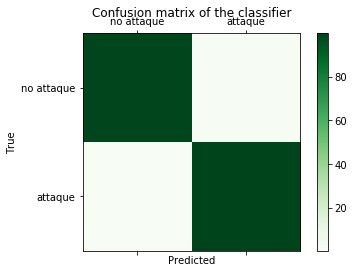

In [84]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
# training
clf = clf.fit(X_train_new, y_train)
# classification
y_pred = clf.predict(X_test_new)
# confusion matrix
do_metrics(y_test,y_pred)
labels = ['no attaque', 'attaque']
cm = metrics.confusion_matrix(y_test, y_pred)
plot_cm(cm, labels)
# performance

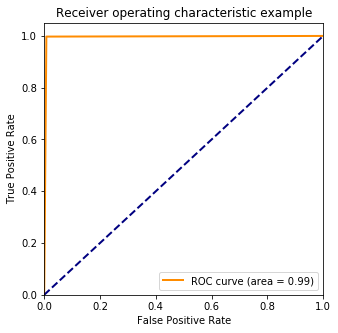

In [85]:
plot_roc(clf,y_test,y_pred)

#### Visualisation de l'arbre de décision 

In [86]:
# import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
# import graphviz
# import pydotplus
# from IPython.display import Image  
# dot_data = tree.export_graphviz(clf, out_file=None, 
#                          feature_names=X_train[[0,2,3,4,7,8,9]].columns,  
#                          class_names=['no attaque', 'attaque'],  
#                          filled=True, rounded=True,  
#                          special_characters=True)  
# graph = pydotplus.graph_from_dot_data(dot_data)  
# Image(graph.create_png())

In [87]:
# graph.write_pdf("tree.pdf")

#### 2 - Algorithme de la logistique régression 

metrics.confusion_matrix:
[[  3585     28]
 [    47 117965]]
metrics.accuracy_score:
0.9993833504624872
metrics.precision_score:
0.9997626977871569
metrics.recall_score:
0.9996017354167372
metrics.f1_score:
0.9996822101226669
Confusion Matrix Stats
no attaque/no attaque: 99.23% (3585/3613)
no attaque/attaque: 0.77% (28/3613)
attaque/no attaque: 0.04% (47/118012)
attaque/attaque: 99.96% (117965/118012)


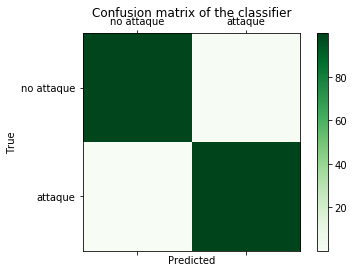

In [88]:
from sklearn.linear_model import LogisticRegression
# classifier
clf_log = LogisticRegression()
# training
clf_log = clf_log.fit(X_train_new, y_train)
# classification
y_pred = clf_log.predict(X_test_new)
# confusion matrix
labels = ['no attaque', 'attaque']
do_metrics(y_test,y_pred)
cm = metrics.confusion_matrix(y_test, y_pred)
plot_cm(cm, labels)

#### 3 - Algorithme du random forest

metrics.confusion_matrix:
[[  3585     28]
 [    67 117945]]
metrics.accuracy_score:
0.999218910585817
metrics.precision_score:
0.9997626575572377
metrics.recall_score:
0.9994322611259872
metrics.f1_score:
0.9995974320401722
Confusion Matrix Stats
no attaque/no attaque: 99.23% (3585/3613)
no attaque/attaque: 0.77% (28/3613)
attaque/no attaque: 0.06% (67/118012)
attaque/attaque: 99.94% (117945/118012)


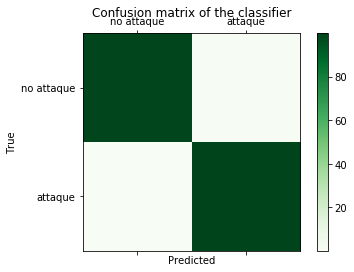

In [110]:
from sklearn.ensemble import RandomForestClassifier
# classifier
clf_rf = RandomForestClassifier()
# training
clf_rf = clf_rf.fit(X_train_new, y_train)
# classification
y_pred = clf_rf.predict(X_test_new)
# confusion matrix
do_metrics(y_test,y_pred)
labels = ['no attaque', 'attaque']
cm = metrics.confusion_matrix(y_test, y_pred)
plot_cm(cm, labels)

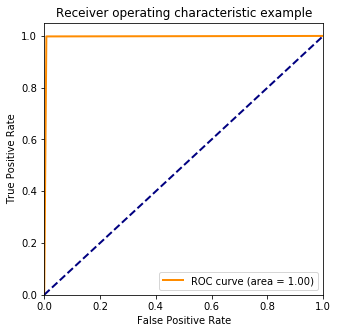

In [90]:
plot_roc(clf_rf,y_test,y_pred)

#### 4 - Algorithme du Adaboost

metrics.confusion_matrix:
[[  3585     28]
 [   194 117818]]
metrics.accuracy_score:
0.998174717368962
metrics.precision_score:
0.9997624017785924
metrics.recall_score:
0.9983560993797241
metrics.f1_score:
0.9990587556919842
Confusion Matrix Stats
no attaque/no attaque: 99.23% (3585/3613)
no attaque/attaque: 0.77% (28/3613)
attaque/no attaque: 0.16% (194/118012)
attaque/attaque: 99.84% (117818/118012)


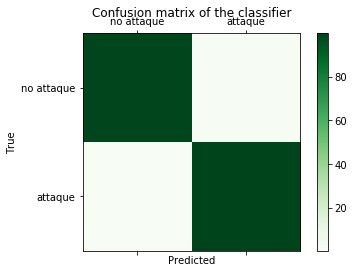

In [91]:
from sklearn.ensemble import AdaBoostClassifier
# classifier
clf_ada = AdaBoostClassifier(n_estimators=100)
# training
clf_ada = clf_ada.fit(X_train_new, y_train)
# classification
y_pred = clf_ada.predict(X_test_new)
# performance
do_metrics(y_test,y_pred)
# confusion matrix
labels = ['no attaque', 'attaque']
cm = metrics.confusion_matrix(y_test, y_pred)
plot_cm(cm, labels)

#### 5 - Algorithme du XGBoost

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


metrics.confusion_matrix:
[[  3585     28]
 [   194 117818]]
metrics.accuracy_score:
0.998174717368962
metrics.precision_score:
0.9997624017785924
metrics.recall_score:
0.9983560993797241
metrics.f1_score:
0.9990587556919842
Confusion Matrix Stats
no attaque/no attaque: 99.23% (3585/3613)
no attaque/attaque: 0.77% (28/3613)
attaque/no attaque: 0.16% (194/118012)
attaque/attaque: 99.84% (117818/118012)


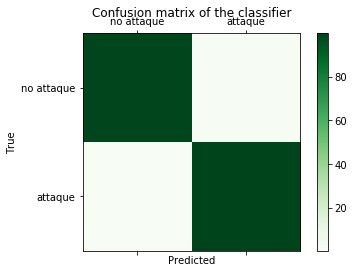

In [92]:
from xgboost.sklearn import XGBClassifier
model = XGBClassifier(max_depth=6, learning_rate=0.03, n_estimators=200, silent=True, objective='binary:logistic')
model.fit(X_train_new, y_train)
ans = model.predict(X_test_new)
do_metrics(y_test, ans)
labels = ['no attaque', 'attaque']
cm = metrics.confusion_matrix(y_test, ans)
plot_cm(cm, labels)

### Réglage des paramètres de RandomForest

#### 1 - le nombre d'estimateurs varient entre 10 et 201 par 20

In [ ]:
# 170 est le meilleur
from sklearn.grid_search import GridSearchCV
param_test1 = {'n_estimators':list(range(10,201,20))}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(), 
                       param_grid = param_test1, scoring='roc_auc',cv=5)
gsearch1.fit(X_train_new, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

#### 2 - 'max_depth' et 'min_samples_split'

In [ ]:
# les meilleurs paramètres : 'max_depth': 11, 'min_samples_split': 2
param_test2 = {'max_depth':list(range(3,20,2)), 'min_samples_split':list(range(2,100,10))}
gsearch2 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 50),
   param_grid = param_test2, scoring='roc_auc',iid=False, cv=5)
gsearch2.fit(X_train_new, y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

#### 3 - 'min_samples_split' et 'min_samples_leaf'

In [95]:
# les meilleurs paramètres : 'min_samples_leaf': 1, 'min_samples_split': 2
param_test3 = {'min_samples_split':list(range(2,100,20)), 'min_samples_leaf':list(range(1,60,10))}
gsearch3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 50, max_depth=15),
   param_grid = param_test3, scoring='roc_auc',iid=False, cv=5)
gsearch3.fit(X_train_new, y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.99782, std: 0.00091, params: {'min_samples_leaf': 1, 'min_samples_split': 2},
  mean: 0.99770, std: 0.00068, params: {'min_samples_leaf': 1, 'min_samples_split': 22},
  mean: 0.99748, std: 0.00067, params: {'min_samples_leaf': 1, 'min_samples_split': 42},
  mean: 0.99746, std: 0.00093, params: {'min_samples_leaf': 1, 'min_samples_split': 62},
  mean: 0.99745, std: 0.00079, params: {'min_samples_leaf': 1, 'min_samples_split': 82},
  mean: 0.99737, std: 0.00059, params: {'min_samples_leaf': 11, 'min_samples_split': 2},
  mean: 0.99760, std: 0.00096, params: {'min_samples_leaf': 11, 'min_samples_split': 22},
  mean: 0.99752, std: 0.00080, params: {'min_samples_leaf': 11, 'min_samples_split': 42},
  mean: 0.99733, std: 0.00098, params: {'min_samples_leaf': 11, 'min_samples_split': 62},
  mean: 0.99726, std: 0.00098, params: {'min_samples_leaf': 11, 'min_samples_split': 82},
  mean: 0.99734, std: 0.00074, params: {'min_samples_leaf': 21, 'min_samples_split': 2},
  mean: 0.99735, s

#### 4 - le nombre maximum des features

In [96]:
# param_test4 = {'max_features':list(range(3,7,1))}
# gsearch4 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 50, max_depth=11, min_samples_split=2,
#                                   min_samples_leaf=1),
#    param_grid = param_test4, scoring='roc_auc',iid=False, cv=5)
# gsearch4.fit(X_train_new, y_train)
# gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

### Détection avec les meilleurs paramètres

#### 1 - Deux types

metrics.confusion_matrix:
[[  3585     28]
 [    22 117990]]
metrics.accuracy_score:
0.9995889003083248
metrics.precision_score:
0.9997627480553813
metrics.recall_score:
0.9998135782801749
metrics.f1_score:
0.9997881625217133
Confusion Matrix Stats
no attaque/no attaque: 99.23% (3585/3613)
no attaque/attaque: 0.77% (28/3613)
attaque/no attaque: 0.02% (22/118012)
attaque/attaque: 99.98% (117990/118012)


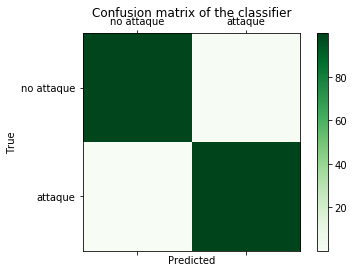

In [106]:
from sklearn.ensemble import RandomForestClassifier
# classifier
clf_rf = RandomForestClassifier(n_estimators = 170, max_depth = 11, min_samples_split = 2,
                                  min_samples_leaf = 1)
# training
clf_rf = clf_rf.fit(X_train_new, y_train)
# classification
y_pred = clf_rf.predict(X_test_new)
# confusion matrix
do_metrics(y_test,y_pred)
labels = ['no attaque', 'attaque']
cm = metrics.confusion_matrix(y_test, y_pred)
plot_cm(cm, labels)

#### 2 - Multiclassification ( logs normaux + 3 types d'attaques)

In [98]:
X_train4 = pd.concat([X_train1,X_train2])
X_test4 = pd.concat([X_test1,X_test2])
y_train4 = pd.concat([y_train1,y_train2])
y_test4 = pd.concat([y_test1,y_test2])

In [99]:
def plot_cm4(cm, labels):
    
    # Compute percentanges
    percent = (cm*100.0)/np.array(np.matrix(cm.sum(axis=1)).T)  # Derp, I'm sure there's a better way
    
    print ('Confusion Matrix Stats')
    for i, label_i in enumerate(labels):
        for j, label_j in enumerate(labels):
            print ("%s/%s: %.2f%% (%d/%d)" % (label_i, label_j, (percent[i][j]), cm[i][j], cm[i].sum()))

    # Show confusion matrix
    # Thanks kermit666 from stackoverflow :)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.grid(b=False)
    cax = ax.matshow(percent, cmap='Greens')
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [100]:
def do_metrics4(y_test,y_pred):
    print ("metrics.confusion_matrix:")
    print (metrics.confusion_matrix(y_test, y_pred))
    print ("metrics.accuracy_score:")
    print (metrics.accuracy_score(y_test, y_pred))

metrics.confusion_matrix:
[[  3589     24      0      0]
 [     0 117818      0      0]
 [     0      0     82      0]
 [     0      0      0    112]]
metrics.accuracy_score:
0.9998026721479959
Confusion Matrix Stats
no attaque/no attaque: 99.34% (3589/3613)
no attaque/brute force: 0.66% (24/3613)
no attaque/sql: 0.00% (0/3613)
no attaque/xss: 0.00% (0/3613)
brute force/no attaque: 0.00% (0/117818)
brute force/brute force: 100.00% (117818/117818)
brute force/sql: 0.00% (0/117818)
brute force/xss: 0.00% (0/117818)
sql/no attaque: 0.00% (0/82)
sql/brute force: 0.00% (0/82)
sql/sql: 100.00% (82/82)
sql/xss: 0.00% (0/82)
xss/no attaque: 0.00% (0/112)
xss/brute force: 0.00% (0/112)
xss/sql: 0.00% (0/112)
xss/xss: 100.00% (112/112)


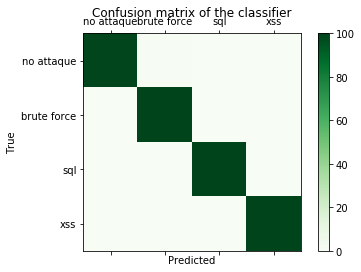

In [107]:
from sklearn.ensemble import RandomForestClassifier
# classifier
clf_rf4 = RandomForestClassifier(n_estimators = 170, max_depth = 11, min_samples_split = 2,
                                  min_samples_leaf = 1)
# training
clf_rf4 = clf_rf4.fit(X_train4, y_train4)
# classification
y_pred4 = clf_rf4.predict(X_test4)
# confusion matrix
do_metrics4(y_test4,y_pred4)
labels = ['no attaque', 'brute force', 'sql','xss']
cm = metrics.confusion_matrix(y_test4, y_pred4)
plot_cm4(cm, labels)